In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, roc_auc_score, confusion_matrix
import copy
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb

In [ ]:
dat = pd.read_pickle('/content/drive/MyDrive/dseb-neu/Senior/HomeCredit/DATA/agg_data (1).pkl')
print(dat.shape)
dat.head()

(307505, 363)


,CODE_GENDER,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,...,CLOSED_AMT_CREDIT_SUM_DEBT_SUM,CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,CLOSED_CNT_CREDIT_PROLONG_SUM,CLOSED_MONTHS_BALANCE_SIZE_SUM,CLOSED_NEW_DEPT_RATIO_MIN,CLOSED_NEW_DEPT_RATIO_MAX,CLOSED_NEW_DEPT_RATIO_MEAN,TARGET
0,0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,-2120,NaN,...,0.0,0.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,1
1,1,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,-291,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,0,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,-4260.0,-2531,26.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,1,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,-9833.0,-2437,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,0,513000.0,21865.5,513000.0,0.028663,-19932,-3038.0,-4311.0,-3458,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [ ]:
temp, test = train_test_split(dat, test_size = 0.15)
train, valid = train_test_split(temp, test_size = 0.2)
train.shape, valid.shape, test.shape

((209103, 363), (52276, 363), (46126, 363))

# LGBM

In [ ]:
train_lgb = copy.deepcopy(train)
valid_lgb = copy.deepcopy(valid)
test_lgb = copy.deepcopy(test)

In [ ]:
for col in train_lgb.columns:
    if '-' in col or ':' in col:
        print(col)

PREV_NAME_PRODUCT_TYPE_walk-in_MEAN
PREV_PRODUCT_COMBINATION_Cash X-Sell: low_MEAN


In [ ]:
train_lgb = train_lgb.rename(columns = {'PREV_NAME_PRODUCT_TYPE_walk-in_MEAN': 'PREV_NAME_PRODUCT_TYPE_walk_in_MEAN',
                                       'PREV_PRODUCT_COMBINATION_Cash X-Sell: low_MEAN': 'PREV_PRODUCT_COMBINATION_Cash_X_Sell_low_MEAN'})

valid_lgb = valid_lgb.rename(columns = {'PREV_NAME_PRODUCT_TYPE_walk-in_MEAN': 'PREV_NAME_PRODUCT_TYPE_walk_in_MEAN',
                                       'PREV_PRODUCT_COMBINATION_Cash X-Sell: low_MEAN': 'PREV_PRODUCT_COMBINATION_Cash_X_Sell_low_MEAN'})

test_lgb = test_lgb.rename(columns = {'PREV_NAME_PRODUCT_TYPE_walk-in_MEAN': 'PREV_NAME_PRODUCT_TYPE_walk_in_MEAN',
                                       'PREV_PRODUCT_COMBINATION_Cash X-Sell: low_MEAN': 'PREV_PRODUCT_COMBINATION_Cash_X_Sell_low_MEAN'})



In [ ]:
lgb_train = lgb.Dataset(data=train_lgb.drop(['SK_ID_CURR', 'TARGET'],axis=1),
                        label=train_lgb.TARGET)
lgb_valid = lgb.Dataset(data=valid_lgb.drop(['SK_ID_CURR', 'TARGET'],axis=1),
                       label=valid_lgb.TARGET)
lgb_test = lgb.Dataset(data=test_lgb.drop(['SK_ID_CURR', 'TARGET'],axis=1),
                      label= test_lgb.TARGET)

In [ ]:
params = {'task': 'train', 
          'boosting_type': 'gbdt', 
          'objective': 'binary', 
          'metric': 'auc', 
          'learning_rate': 0.01, 
          'num_leaves': 20,
          'max_bin': 20,
          'num_iteration': 1000,
          'colsample_bytree':.8, 
          'subsample':.9, 
          'max_depth':7, 
          'reg_alpha':.1, 
          'reg_lambda':.1, 
          'min_split_gain':.01, 
          'min_child_weight':1}
model_lgb_base = lgb.train(params, lgb_train, verbose_eval=50, num_boost_round=200,
                      valid_sets=[lgb_train, lgb_valid], early_stopping_rounds=50)

/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_iteration` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 16982, number of negative: 192121
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.199025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6788
[LightGBM] [Info] Number of data points in the train set: 209103, number of used features: 361
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.081214 -> initscore=-2.425971
[LightGBM] [Info] Start training from score -2.425971
Training until validation scores don't improve for 50 rounds
[50]	training's auc: 0.744945	valid_1's auc: 0.738402
[100]	training's auc: 0.753157	valid_1's auc: 0.745161
[150]	training's auc: 0.760594	valid_1's auc: 0.750487
[200]	training's auc: 0.767094	valid_1's auc: 0.755

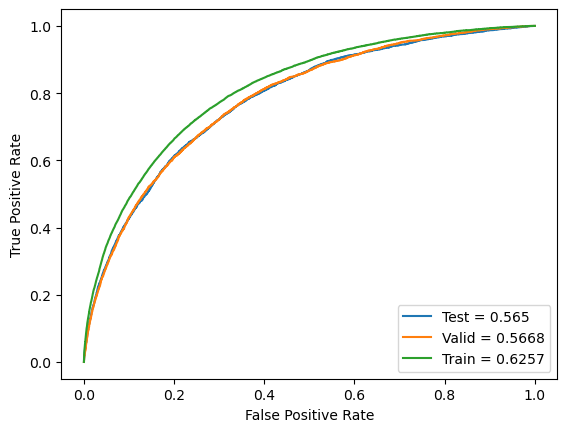

In [ ]:
import matplotlib.pyplot as plt

def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    (true_y_test, true_y_valid, true_y_train) = true_y
    (y_prob_test, y_prob_valid, y_prob_train) = y_prob
    fpr_test, tpr_test, thresholds = roc_curve(true_y_test, y_prob_test)
    fpr_valid, tpr_valid, thresholds = roc_curve(true_y_valid, y_prob_valid)
    fpr_train, tpr_train, thresholds = roc_curve(true_y_train, y_prob_train)
    
    gini_test = 2 * roc_auc_score(true_y_test, y_prob_test) - 1
    gini_valid = 2 * roc_auc_score(true_y_valid, y_prob_valid) - 1
    gini_train = 2 * roc_auc_score(true_y_train, y_prob_train) - 1
    
    plt.plot(fpr_test, tpr_test, label = 'Test = {}'.format(np.round(gini_test, 4)))
    plt.plot(fpr_valid, tpr_valid, label = 'Valid = {}'.format(np.round(gini_valid, 4)))
    plt.plot(fpr_train, tpr_train, label = 'Train = {}'.format(np.round(gini_train, 4)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=4)
    

pred_test = model_lgb_base.predict(test_lgb.drop(['SK_ID_CURR', 'TARGET'],axis=1))
pred_valid = model_lgb_base.predict(valid_lgb.drop(['SK_ID_CURR', 'TARGET'],axis=1))
pred_train = model_lgb_base.predict(train_lgb.drop(['SK_ID_CURR', 'TARGET'],axis=1))

plot_roc_curve(true_y = (test_lgb['TARGET'], valid_lgb['TARGET'], train_lgb['TARGET']), 
               y_prob = (pred_test, pred_valid, pred_train))

# WOE Transformation + Logit

## Transformation

In [ ]:
def iv_woe(data, target, bins=10, show_woe=False):
    
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
#     for ivars in ['AMT_REQ_CREDIT_BUREAU_YEAR']:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        
        # missing
        if d0.isnull().sum().sum() > 0 :
            try:
                d0['x'] = d0['x'].cat.add_categories('Missing')
                d0['x'].fillna('Missing', inplace =True)
            except:
#                 print('var ', ivars)
                d0['x'].fillna('Missing', inplace =True)

            
        # Calculate the number of events in each group (bin)
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        
        # Calculate % of events in each group.
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()

        # Calculate the non events in each group.
        d['Non-Events'] = d['N'] - d['Events']
        # Calculate % of non events in each group.
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()

        # Calculate WOE by taking natural log of division of % of non-events and % of events
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
#         print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF

In [ ]:
newDF, woeDF = iv_woe(data = train.drop(columns = ['SK_ID_CURR']),
                        target = 'TARGET')

In [ ]:
newDF[newDF['IV']>= 0.02]

,Variable,IV
0,CODE_GENDER,0.040898
0,AMT_CREDIT,0.045493
0,AMT_ANNUITY,0.027297
0,AMT_GOODS_PRICE,0.089100
0,REGION_POPULATION_RELATIVE,0.033872
...,...,...
0,CLOSED_CNT_CREDIT_PROLONG_SUM,0.036090
0,CLOSED_MONTHS_BALANCE_SIZE_SUM,0.038727
0,CLOSED_NEW_DEPT_RATIO_MIN,0.031150
0,CLOSED_NEW_DEPT_RATIO_MAX,0.031745


In [ ]:
# chon bien co IV >= 0.02
woeDF[woeDF['Variable'].isin(newDF[newDF['IV']>= 0.02]['Variable'])]

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,CODE_GENDER,0,71530,7340,0.432222,64190,0.334112,0.257463,0.025260
1,CODE_GENDER,1,137573,9642,0.567778,127931,0.665888,-0.159391,0.015638
0,AMT_CREDIT,"(44999.999, 180000.0]",22625,1509,0.088859,21116,0.109910,-0.212612,0.004476
1,AMT_CREDIT,"(180000.0, 254700.0]",21579,1706,0.100459,19873,0.103440,-0.029239,0.000087
2,AMT_CREDIT,"(254700.0, 306000.0]",18577,1555,0.091568,17022,0.088600,0.032940,0.000098
...,...,...,...,...,...,...,...,...,...
1,CLOSED_NEW_DEPT_RATIO_MAX,"(0.0, 8933238.0]",3496,308,0.018137,3188,0.016594,0.088922,0.000137
2,CLOSED_NEW_DEPT_RATIO_MAX,Missing,60613,6205,0.365387,54408,0.283197,0.254816,0.020943
0,CLOSED_NEW_DEPT_RATIO_MEAN,"(-33981.166, 0.0]",145008,10471,0.616594,134537,0.700272,-0.127258,0.010649
1,CLOSED_NEW_DEPT_RATIO_MEAN,"(0.0, 2233309.746]",3482,306,0.018019,3176,0.016531,0.086179,0.000128


In [ ]:
woeDF.shape

(3137, 9)

In [ ]:
transform_woe_df = woeDF[woeDF['Variable'].isin(newDF[newDF['IV']>= 0.02]['Variable'])]
transform_woe_df.shape

(3090, 9)

In [ ]:
transform_woe_df.head()

,Variable,Cutoff,N,Events,% of Events,Non-Events,% of Non-Events,WoE,IV
0,CODE_GENDER,0,71530,7340,0.432222,64190,0.334112,0.257463,0.025260
1,CODE_GENDER,1,137573,9642,0.567778,127931,0.665888,-0.159391,0.015638
0,AMT_CREDIT,"(44999.999, 180000.0]",22625,1509,0.088859,21116,0.109910,-0.212612,0.004476
1,AMT_CREDIT,"(180000.0, 254700.0]",21579,1706,0.100459,19873,0.103440,-0.029239,0.000087
2,AMT_CREDIT,"(254700.0, 306000.0]",18577,1555,0.091568,17022,0.088600,0.032940,0.000098


In [ ]:
final_list = list(transform_woe_df['Variable'].unique())
print(len(final_list))
keep_cols = final_list + ['TARGET']
print(len(keep_cols), keep_cols)

356
357 ['CODE_GENDER', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAREA_MEDI', 'TOTALAREA_MODE', 'DAYS_LAST_PHONE_CHANGE', 'NEW_REGION', 'NEW_DOCUMENT', 'NEW_DAYS_EMPLOYED_RATIO', 'NEW_PAYMENT_RATIO', 'NEW_EXTSOURCE_MEAN', 'NEW_EXTSOURCES_WPOINT', 'NEW_GOODS_C

In [ ]:
map_transform_dict = {}
for idx in range(transform_woe_df.shape[0]):
    var = transform_woe_df.iloc[idx]['Variable']
    cutoff = transform_woe_df.iloc[idx]['Cutoff']
    woe = float(transform_woe_df.iloc[idx]['WoE'])
    
    if var not in map_transform_dict:
        map_transform_dict[var] = [[], []]  ## cutoff, woe
    if str(cutoff) == 'Missing':
        map_transform_dict[var][0].append('Missing')
    elif '(' not in str(cutoff):
        map_transform_dict[var][0].append(cutoff)
    elif '(' in str(cutoff):
        cutoff_str = str(cutoff).replace('(', '').replace(']', '')
        upper = cutoff_str.split(',')[0]
        lower = cutoff_str.split(',')[-1]
        map_transform_dict[var][0].append([upper, lower])
    map_transform_dict[var][1].append(woe)

In [ ]:
from tqdm import tqdm
def map_woe_values(data, map_transform_dict):
    data = data.reset_index().drop(columns = ['index'])
    data_copy = copy.deepcopy(data)
    
    for var in tqdm(map_transform_dict.keys()):
#     for var in ['AMT_CREDIT', 'APPROVED_NEWX2_FLAG_AMT_CREDIT_RATIO_MIN']:
        try:
            cutoff_lst, woe_lst = map_transform_dict[var]
            for idx in range(len(cutoff_lst)):
                cutoff = cutoff_lst[idx]
                woe = woe_lst[idx]
                if type(cutoff) == int:
                    data[var] = data[var].replace({cutoff: woe})

                elif type(cutoff) == str:
                    if str(cutoff) != 'Missing':
                        data[var] = data[var].replace({cutoff: woe})
                    elif str(cutoff) == 'Missing':
                        data[var] = data[var].fillna(woe)
                elif type(cutoff) == float:
                    data[var] = data[var].map({cutoff: woe})

                elif len(cutoff) == 1:
                    if str(cutoff) != 'Missing':
                        data[var] = data[var].map({cutoff: woe})

                elif len(cutoff) == 2:
                    upper = float(cutoff[0])
                    lower = float(cutoff[-1])
                    index_ = data_copy[(data_copy[var]> upper)&
                                       (data_copy[var]<= lower)].index
                    data.iloc[index_, data.columns.get_loc(var)] = woe
        except:
            print('FAIL ', var)
                
    return data, data_copy

In [ ]:
train_w = train[keep_cols].reset_index().drop(columns = ['index'])
train_temp = copy.deepcopy(train_w)
train_map, train_copy = map_woe_values(data = train_temp, map_transform_dict = map_transform_dict)
train_map[['CODE_GENDER', 'AMT_CREDIT', 'APPROVED_NEWX2_FLAG_AMT_CREDIT_RATIO_MIN']].head()

100%|██████████| 356/356 [02:01<00:00,  2.94it/s]


,CODE_GENDER,AMT_CREDIT,APPROVED_NEWX2_FLAG_AMT_CREDIT_RATIO_MIN
0,0.257463,-0.029239,-0.296385
1,0.257463,-0.443258,-0.296385
2,-0.159391,0.177740,-0.296385
3,0.257463,-0.212612,-0.296385
4,-0.159391,0.052936,-0.296385


In [ ]:
train_map.head()

,CODE_GENDER,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,...,CLOSED_AMT_CREDIT_SUM_DEBT_SUM,CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,CLOSED_CNT_CREDIT_PROLONG_SUM,CLOSED_MONTHS_BALANCE_SIZE_SUM,CLOSED_NEW_DEPT_RATIO_MIN,CLOSED_NEW_DEPT_RATIO_MAX,CLOSED_NEW_DEPT_RATIO_MEAN,TARGET
0,0.257463,-0.029239,-0.178347,0.113088,0.169411,-0.519172,-0.412383,0.063892,-0.336417,-0.237194,...,-0.125022,-0.119846,-0.141295,-0.120780,0.299835,-0.159495,-0.122585,-0.127360,-0.127258,0
1,0.257463,-0.443258,-0.362735,-0.536917,-0.607463,-0.026823,-0.640436,-0.052736,-0.263475,0.060427,...,-0.125022,-0.119846,-0.141295,-0.120780,0.299835,-0.118395,-0.122585,-0.127360,-0.127258,0
2,-0.159391,0.177740,0.083318,-0.206641,0.176964,-0.015259,0.352282,0.063892,-0.336417,0.060427,...,-0.125022,-0.119846,-0.141295,-0.120780,0.299835,-0.118395,-0.122585,-0.127360,-0.127258,0
3,0.257463,-0.212612,0.042281,-0.117316,-0.157923,0.397303,-0.083394,0.084459,0.159114,0.066190,...,-0.125022,-0.119846,-0.141295,-0.120780,0.299835,-0.118395,-0.122585,-0.127360,-0.127258,0
4,-0.159391,0.052936,0.083318,-0.362452,-0.004298,0.085360,0.047075,0.204962,-0.066214,0.060427,...,0.299835,0.299835,0.220541,0.299835,0.299835,0.299835,0.254816,0.254816,0.254816,0


In [ ]:
train_map.isnull().sum().sum()

0

In [ ]:
valid_w = valid[keep_cols].reset_index().drop(columns = ['index'])
valid_temp = copy.deepcopy(valid_w)
valid_map, valid_copy = map_woe_values(data = valid_temp, map_transform_dict = map_transform_dict)
valid_map.head()

100%|██████████| 356/356 [00:33<00:00, 10.68it/s]


,CODE_GENDER,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,...,CLOSED_AMT_CREDIT_SUM_DEBT_SUM,CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,CLOSED_CNT_CREDIT_PROLONG_SUM,CLOSED_MONTHS_BALANCE_SIZE_SUM,CLOSED_NEW_DEPT_RATIO_MIN,CLOSED_NEW_DEPT_RATIO_MAX,CLOSED_NEW_DEPT_RATIO_MEAN,TARGET
0,-0.159391,-0.145288,-0.041035,-0.362452,-0.607463,0.397303,0.352282,0.204962,0.256091,0.060427,...,0.299835,0.299835,0.220541,0.299835,0.299835,0.299835,0.254816,0.254816,0.254816,0
1,0.257463,-0.443258,-0.362735,-0.536917,0.062208,-0.026823,0.352282,-0.052736,-0.222442,0.060427,...,-0.125022,-0.119846,-0.141295,-0.120780,0.299835,-0.118395,-0.122585,-0.127360,-0.127258,0
2,0.257463,0.230237,0.083318,0.224992,-0.004298,-0.015259,-0.323436,-0.120024,-0.336417,0.060427,...,0.299835,0.299835,0.220541,0.299835,0.299835,0.299835,0.254816,0.254816,0.254816,0
3,-0.159391,-0.443258,-0.041035,-0.536917,-0.092520,-0.130566,0.352282,0.084459,0.159114,0.129489,...,-0.125022,-0.119846,-0.068807,-0.068807,0.299835,-0.118395,-0.122585,-0.127360,-0.127258,0
4,-0.159391,0.052936,0.142281,0.044798,-0.034268,-0.260901,-0.412383,-0.388369,-0.066214,0.060427,...,-0.125022,-0.119846,-0.141295,-0.120780,0.299835,-0.118395,-0.122585,-0.127360,-0.127258,0


In [ ]:
test_w = test[keep_cols].reset_index().drop(columns = ['index'])
test_temp = copy.deepcopy(test_w)
test_map, test_copy = map_woe_values(data = test_temp, map_transform_dict = map_transform_dict)
test_map.head()

100%|██████████| 356/356 [00:29<00:00, 12.19it/s]


,CODE_GENDER,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,...,CLOSED_AMT_CREDIT_SUM_DEBT_SUM,CLOSED_AMT_CREDIT_SUM_OVERDUE_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,CLOSED_CNT_CREDIT_PROLONG_SUM,CLOSED_MONTHS_BALANCE_SIZE_SUM,CLOSED_NEW_DEPT_RATIO_MIN,CLOSED_NEW_DEPT_RATIO_MAX,CLOSED_NEW_DEPT_RATIO_MEAN,TARGET
0,0.257463,0.177740,0.052572,0.550626,-0.092520,0.345184,0.047075,0.100620,0.159114,-0.059055,...,-0.125022,-0.119846,-0.141295,-0.120780,0.299835,-0.159495,-0.122585,-0.127360,-0.127258,0
1,0.257463,0.305602,0.047210,0.550626,-0.607463,-0.260901,-0.179943,0.204962,-0.066214,0.060427,...,0.299835,0.299835,0.220541,0.299835,0.299835,0.299835,0.254816,0.254816,0.254816,1
2,-0.159391,0.052936,0.047210,0.044798,-0.092520,0.196328,-0.179943,-0.052736,0.205015,-0.272100,...,-0.125022,-0.119846,-0.141295,-0.120780,0.299835,0.026384,-0.122585,-0.127360,-0.127258,0
3,-0.159391,-0.443258,-0.362735,-0.222923,-0.157923,-0.519172,0.272737,-0.388369,-0.263475,0.060427,...,0.299835,0.299835,0.220541,0.299835,0.299835,0.299835,0.254816,0.254816,0.254816,0
4,-0.159391,0.230237,0.042281,0.113088,0.163774,0.397303,0.359207,0.063892,0.205015,0.066190,...,0.299835,0.299835,0.220541,0.299835,0.299835,0.299835,0.254816,0.254816,0.254816,0


In [ ]:
train_map.isnull().sum().sum(), valid_map.isnull().sum().sum(), test_map.isnull().sum().sum()

(0, 0, 0)

In [ ]:
train_map_w = train_map[np.isfinite(train_map).all(1)]
valid_map_w = valid_map[np.isfinite(valid_map).all(1)]
test_map_w  = test_map[np.isfinite(test_map).all(1)]

In [ ]:
train_map.to_pickle('agg_train_woe.pkl')
valid_map.to_pickle('agg_valid_woe.pkl')
test_map.to_pickle('agg_test_woe.pkl')

## MODEL

In [ ]:
log_reg_w = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg_w.fit(train_map_w.drop(['TARGET'],axis=1), train_map_w['TARGET'])

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(C=0.0001)

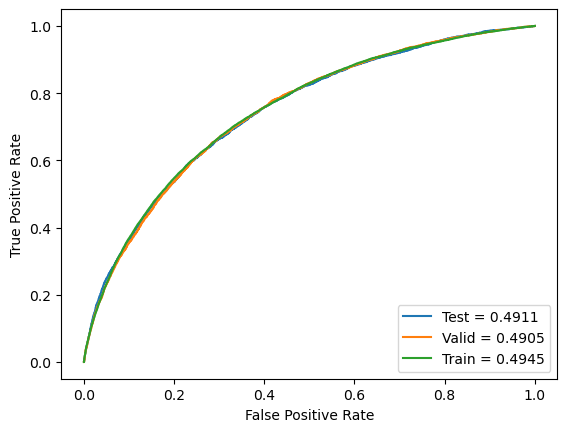

In [ ]:
import matplotlib.pyplot as plt

def plot_roc_curve(true_y, y_prob):
    """
    plots the roc curve based of the probabilities
    """
    (true_y_test, true_y_valid, true_y_train) = true_y
    (y_prob_test, y_prob_valid, y_prob_train) = y_prob
    fpr_test, tpr_test, thresholds = roc_curve(true_y_test, y_prob_test)
    fpr_valid, tpr_valid, thresholds = roc_curve(true_y_valid, y_prob_valid)
    fpr_train, tpr_train, thresholds = roc_curve(true_y_train, y_prob_train)
    
    gini_test = 2 * roc_auc_score(true_y_test, y_prob_test) - 1
    gini_valid = 2 * roc_auc_score(true_y_valid, y_prob_valid) - 1
    gini_train = 2 * roc_auc_score(true_y_train, y_prob_train) - 1
    
    plt.plot(fpr_test, tpr_test, label = 'Test = {}'.format(np.round(gini_test, 4)))
    plt.plot(fpr_valid, tpr_valid, label = 'Valid = {}'.format(np.round(gini_valid, 4)))
    plt.plot(fpr_train, tpr_train, label = 'Train = {}'.format(np.round(gini_train, 4)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc=4)
    

pred_test = log_reg_w.predict_proba(test_map_w.drop(['TARGET'],axis=1))[:, 1]
pred_valid = log_reg_w.predict_proba(valid_map_w.drop(['TARGET'],axis=1))[:, 1]
pred_train = log_reg_w.predict_proba(train_map_w.drop(['TARGET'],axis=1))[:, 1]

plot_roc_curve(true_y = (test_map_w['TARGET'], valid_map_w['TARGET'], train_map_w['TARGET']), 
               y_prob = (pred_test, pred_valid, pred_train))